<a href="https://colab.research.google.com/github/2003UJAN/Image-Segmentation-For-Self-Driving-Cars/blob/main/Image_Segmentation_For_Self_Driving_Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F22655%2F29047%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T181555Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D80a9140596bd60321adb8675b398c40707d2762faffde2851606e9cf5ef4598a0a5d3fbe7efe0b82d1b205b259a78a5b5f1b3ab966603a19b9bd11b2aa171559471c2972784d500693401bcea7e15bb083773640d8733891a88cecfe4ae14dbc4696106d8f5a5e94f8fe7ea619cdd65dc00659fac31daea8a43df78da7384cd611fb9bf52aa7c5c21b681e5b97d947cece3240cff6c6061d69b7451559d944b17eb692d09c885ec25d60014eeca69812c7dec83497a97d1ece208a07c36593a40d73935e02075441bdd78f2b575ff4888e3b81ce9ab78a652fcb6acce3c3b411a5d5c2d7fbc123565caed1c8743d241a87586de90ee2ef9b9d66581cb7c9ad62'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 211492512 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

In [3]:
def LoadImage(name, path="../input/cityscapes_data/cityscapes_data/train",
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 200)):
    img = Image.open(path+"/"+name)
    img = np.array(img)
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]

    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg

    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)



    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]

        #seg = np.round(seg/255.0)

    return img/255, seg/255

In [4]:
files =os.listdir("../input/cityscapes_data/cityscapes_data/train")[0:10]

colors = []
for file in files:
    img, seg = LoadImage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(13)
km.fit(colors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=13)

In [5]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]

    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]

        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

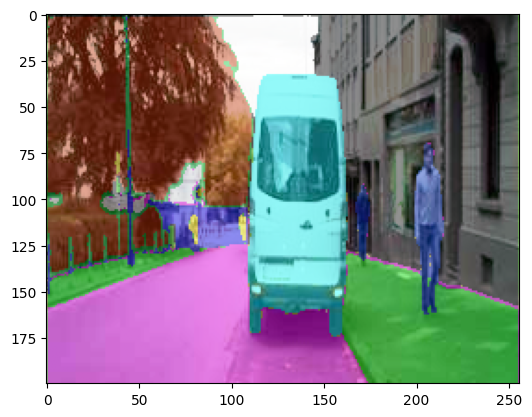

In [6]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))

    n = len(km.cluster_centers_)

    cls = np.zeros((seg.shape[0], seg.shape[1], n))

    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1

        cls[:,:,i]=m

    return cls

img, seg = LoadImage("174.jpg")
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
plot.imshow(total[:,:,:])
plot.show()

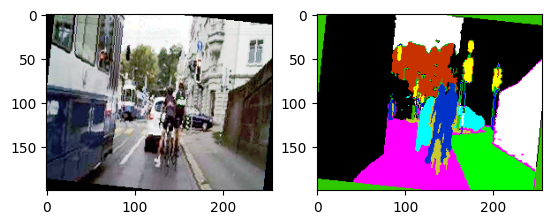

In [7]:
def Generate(path="../input/cityscapes_data/cityscapes_data/train", batch_size=10,
            maxangle=10.0):

    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]

        for i in range(batch_size):
            file = random.sample(files,1)[0]

            flip=False
            if random.random() > 0.5:
                flip=True

            angle = maxangle*(random.random()*2-1)

            img, seg = LoadImage(file, path, rotation=angle, flip=flip)

            seg = ColorsToClass(seg)

            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)

gen = Generate()
imgs, segs = next(gen)

plot.subplot(121)
plot.imshow(imgs[0])
plot.subplot(122)
plot.imshow(LayersToRGBImage(segs[0]))
plot.show()

In [8]:
inp = Input(shape=(200, 256, 3))

x1 = BatchNormalization()(inp)
x1 = Conv2D(64, 12, activation="relu", padding="same")(x1)
x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
p1 = MaxPooling2D()(x1)
#p1 = Dropout(0.2)(p1)

#x2 = BatchNormalization()(x1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
p2 = MaxPooling2D()(x2)
#p2 = Dropout(0.2)(p2)

#x3 = BatchNormalization()(x2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)
p3 = MaxPooling2D()(x3)
#p3 = Dropout(0.2)(p3)

#x4 = BatchNormalization()(x3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)
#x4 = MaxPooling2D()(x4)
#x4 = Dropout(0.2)(x4)

x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
#x5 = Dropout(0.2)(x5)

x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
#x6 = Dropout(0.2)(x6)

x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(13, 6, activation="relu", padding="same")(x7)
x7 = Conv2D(13, 6, activation="softmax", padding="same")(x7)



model = Model(inp, x7)

opt = Adam(lr=0.0001)
model.compile(optimizer=opt,
             loss="categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 256, 3)]        0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 200, 256, 3)          12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 200, 256, 64)         27712     ['batch_normalization[0][0]'] 
                                                                                                  
 conv2d_1 (Conv2D)           (None, 200, 256, 128)        1179776   ['conv2d[0][0]']          

In [9]:
train_gen = Generate()
val_gen = Generate("../input/cityscapes_data/cityscapes_data/val")

In [ ]:
clb = [ModelCheckpoint("loss.h5", save_best_only=True, verbose=0)]

h = model.fit_generator(train_gen, epochs=1000, steps_per_epoch=10,
                       validation_data=val_gen, validation_steps=10,
                       callbacks=clb, verbose=0)

<ipython-input-10-75f3aaa85cdb>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(train_gen, epochs=1000, steps_per_epoch=10,
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`

In [ ]:
model.save("model.h5")
model = load_model("loss.h5")

In [ ]:
loss = h.history["val_loss"]
acc = h.history["val_acc"]

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

In [ ]:
test_gen = Generate("../input/cityscapes_data/cityscapes_data/val")
max_show=20
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])

        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(12,6))
        plot.subplot(121)
        plot.title("Prediction")
        plot.imshow(predimg)
        plot.axis("off")
        plot.subplot(122)
        plot.title("True")
        plot.imshow(trueimg)
        plot.axis("off")
        plot.tight_layout()
        plot.savefig("pred_"+str(i)+".png", dpi=150)
        plot.show()
    break

In [ ]:
from sklearn.metrics import roc_curve, balanced_accuracy_score
test_gen = Generate("../input/cityscapes_data/cityscapes_data/val", batch_size=200)
max_show=20

bass = []

for imgs, segs in test_gen:
    p = model.predict(imgs)

    plot.figure(figsize=(10, 10))
    for i in range(p.shape[-1]):
        fpr, tpr, _ = roc_curve(segs[:,:,:,i].ravel(), p[:,:,:,i].ravel())

        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        bas = balanced_accuracy_score(segs[:,:,:,i].ravel(), _p)

        bass.append(bas)

        plot.subplot(4,4,i+1)
        plot.plot(fpr, tpr)
        plot.title("Class "+str(i))
        plot.xlabel("False positive rate")
        plot.ylabel("True positive rate")

    plot.tight_layout()
    plot.show()

    break

In [ ]:
plot.figure(figsize=(8, 5))
plot.bar(np.arange(0, len(bass)), bass)
plot.xticks(np.arange(0, len(bass)))
plot.ylabel("Balanced Accuracy")
plot.xlabel("Class")
plot.tight_layout()
plot.savefig("bas.png")
plot.show()